# Ice fitting workshop - 15/October/2024

### Silicate subtraction

Silicate has two strong features in the infrared, i.e., 9.8 $\mu$m and 18 $\mu$m, which are clearly visible in most of the protostellar spectrum. Some molecules in ices, also have abosorption bands around 9 $\mu$m. For this reason, the silicate features must be subtracted off in order to isolate the ice bands.

In this example, we're focusing on the background star NIR38. In this case, the 18 $\mu$m band is not visible becasue it is below the sensitivity limit of the MIRI/LRS instrument.

The two common methods to extract the silicate features are:

1) Local polynomial continuum;

2) Silciate template subtraction.

In this tutorial we focus on the second methodology. In particular, we use the silicate profile observed the source GCS3, which is taken from Kemper et al. (2004), ApJ, 609, 826.
This methodology was also adopted by Bottinelli et al. (2010), ApJ, 718, 1100.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.interpolate import interp1d
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model
from lmfit.model import save_modelresult
import site
%matplotlib inline
#%matplotlib notebook

/Users/willrocha/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#======================================================================
print('Performing deconvolution by Lorentzian or Gaussian of the silicate profile...')
#======================================================================

def get_line_number2(value, matrix):
    """
    Function used to get the line number of a value in a array.
    
    Parameters
    -------------
    
    value : 'float'
        Value of interest.
    
    matrix : 'numpy.ndarray'
        Vector with the value of interest.
    
    Returns
    ------------
    
    Index
        
    """
    for i, line in enumerate(matrix, 1):
        if line == value:
            return i


def find_nearest(array, value):
    """
    Find nearest value of a given number.
    
    Parameters
    -------------
    
    array : 'numpy.ndarray'
        Vector with the value of interest.
    
    value : 'float'
        Value of interest.
    
    Returns
    -------------
    Nearest value
        
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
dir = os.getcwd()


Performing deconvolution by Lorentzian or Gaussian of the silicate profile...


In [3]:
def extract_silicate(filename, xmin, xmax, npoints, silicate_guess_factor):
    """
    Used to combine files in the genetic algorithm spectral decomposition.
    
    Parameters
    -------------
    
    filename : 'str'
        Optical depth file.
    
    xmin, xmax : 'float'
        Range used in the spectral decomposition.
    
        
    
    Returns
    -------------
    
    File 'New_tau_no_silic_'+name_source+'.txt' With the optical depth without the silicate profile.
    
    """
    fig = plt.figure(figsize=(20,10.0))
    ###################SILICATE PROFILE############
    DIR = os.getcwd() + '/'
    tau_data = filename
    t = np.loadtxt(tau_data, skiprows=1).T
    xtau = t[0]
    ytau = t[1]
    etau = t[2]
    
    
    name_source = filename.split('.')[0]
    
    #t0 = np.loadtxt('Silicate_GCS3_new.out').T
    t0 = np.loadtxt('GCS3.dat').T
    x_silic0 = t0[0]
    y_silic0 = t0[1]*silicate_guess_factor
    
    #exit()
    
    npoints = npoints
    pp1 = find_nearest(xtau, xmin)
    pp2 = find_nearest(xtau, xmax)
    
    tt = np.linspace(pp1, pp2, int(npoints))
    
    
    Fd_silic0 = interp1d(x_silic0,y_silic0, kind='linear')    #interpolate silicate data
    Fsilic0 = Fd_silic0(tt)
    
    Finp0 = interp1d(xtau,ytau, kind='linear')    #interpolate silicate data
    Finp = Finp0(tt)
    
    Fetau0 = interp1d(xtau,etau, kind='linear')    #interpolate silicate data
    Fetau = Fetau0(tt)
    
    plt.plot(tt, Fsilic0, label='CGS3 silicate (guess)', color='limegreen')
    
    tau_nosilic = Finp - Fsilic0
    
    np.savetxt('Removed_silicate_spectrum.txt', np.transpose([tt, tau_nosilic,Fetau]))
    
    
    taumax = max(ytau) + 0.1*max(ytau)
    
    plt.plot(xtau, ytau, color= 'black', label=name_source)
    plt.plot(tt, tau_nosilic, color= 'blue', label=name_source+' '+'(Removed Silicate)')
    #plt.plot(tt, ytau*0., ':', color='lightgrey')
    plt.minorticks_on()
    plt.tick_params(which='major', direction='in', labelsize=10)
    plt.tick_params(which='minor', direction='in', labelsize=10)
    plt.xlim(min(tt),max(tt))
    plt.ylim(taumax,-0.1)
    plt.legend(loc='best', frameon=False, fontsize=9)
    plt.ylabel(r'Optical Depth$\mathrm{(\tau_{\lambda})}$',fontsize=10)
    plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=10)
    
    plt.savefig('Silicate_extract.pdf',format='pdf', bbox_inches='tight', dpi=300)

In [4]:
def extract_silicate_M2(filename, xmin, xmax, npoints, ol_fac=0.5, pyr_fac=0.5):
    """
    Used to combine files in the genetic algorithm spectral decomposition.
    
    Parameters
    -------------
    
    filename : 'str'
        Optical depth file.
    
    xmin, xmax : 'float'
        Range used in the spectral decomposition.
    
        
    
    Returns
    -------------
    
    File 'New_tau_no_silic_'+name_source+'.txt' With the optical depth without the silicate profile.
    
    """
    fig = plt.figure(figsize=(20,10.0))
    ###################SILICATE PROFILE############
    DIR = os.getcwd() + '/'
    tau_data = filename
    t = np.loadtxt(tau_data, skiprows=1).T
    xtau = t[0]
    ytau = t[1]
    etau = t[2]
    
    
    name_source = filename.split('.')[0]
    
    #t0 = np.loadtxt('Silicate_GCS3_new.out').T
    t0 = np.loadtxt('three_silicates.dat', skiprows=1).T
    x_silic0 = t0[0]
    y_silic0 = t0[2]*ol_fac + t0[3]*pyr_fac
    
    #exit()
    
    npoints = len(xtau)
    pp1 = find_nearest(xtau, xmin)
    pp2 = find_nearest(xtau, xmax)
    
    tt = np.linspace(pp1, pp2, int(npoints))
    
    
    Fd_silic0 = interp1d(x_silic0,y_silic0, kind='linear')    #interpolate silicate data
    Fsilic0 = Fd_silic0(tt)
    
    Finp0 = interp1d(xtau,ytau, kind='linear')    #interpolate silicate data
    Finp = Finp0(tt)
    
    Fetau0 = interp1d(xtau,etau, kind='linear')    #interpolate silicate data
    Fetau = Fetau0(tt)
    
    plt.plot(tt, Fsilic0, label='CGS3 silicate (guess)', color='limegreen')
    
    tau_nosilic = Finp - Fsilic0
    
    np.savetxt('Removed_silicate_spectrum.txt', np.transpose([tt, tau_nosilic,Fetau]))
    
    
    taumax = max(ytau) + 0.1*max(ytau)
    
    plt.plot(xtau, ytau, color= 'black', label=name_source)
    #plt.plot(x_silic0, t0[1]*ens_fac, color= 'red', linestyle=':', label='Enstatite - MgSiO$_3$')
    plt.plot(x_silic0, t0[2]*ol_fac, color= 'red', linestyle='--', label='Olivine - MgFeSiO$_4$')
    plt.plot(x_silic0, t0[3]*pyr_fac, color= 'red', linestyle='-.', label='Pyroxene - Mg$_{0.7}$Fe$_{0.3}$SiO$_3$')
    plt.plot(tt, tau_nosilic, color= 'blue', label=name_source+' '+'(Removed Silicate)')
    #plt.plot(tt, ytau*0., ':', color='lightgrey')
    plt.minorticks_on()
    plt.tick_params(which='major', direction='in', labelsize=14)
    plt.tick_params(which='minor', direction='in', labelsize=14)
    plt.xlim(min(tt),max(tt))
    plt.ylim(taumax,-0.1)
    plt.legend(loc='best', frameon=False, fontsize=12)
    plt.ylabel(r'Optical Depth$\mathrm{(\tau_{\lambda})}$',fontsize=15)
    plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=15)
    
    plt.savefig('Silicate_extract.pdf',format='pdf', bbox_inches='tight', dpi=300)

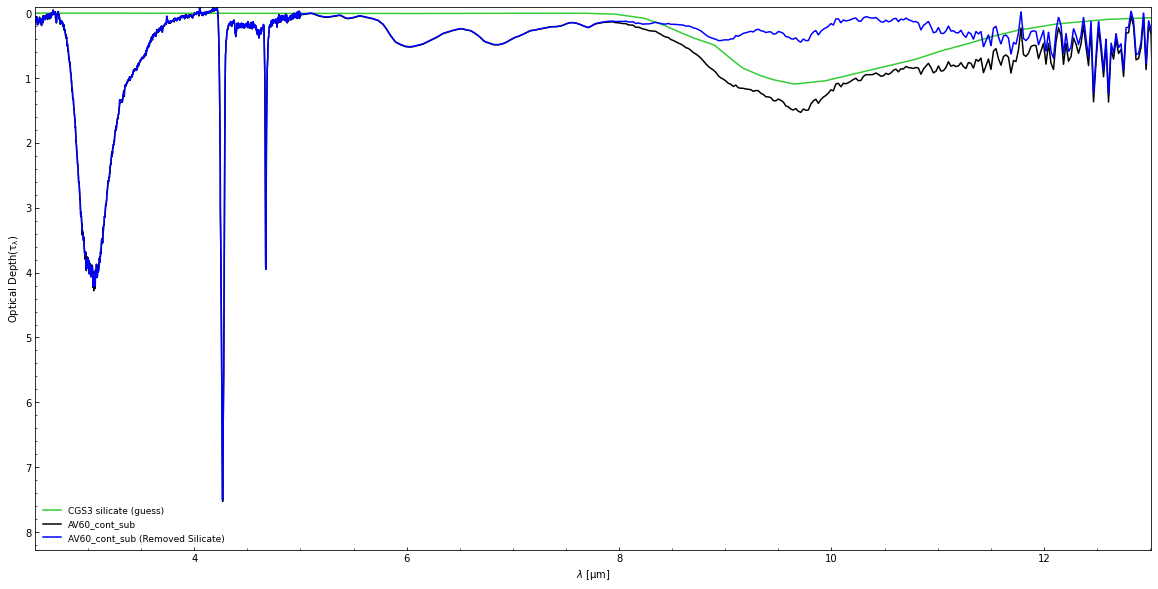

In [5]:
filename = 'AV60_cont_sub.od'
extract_silicate(filename, 2.5, 13., 5000, 0.8)

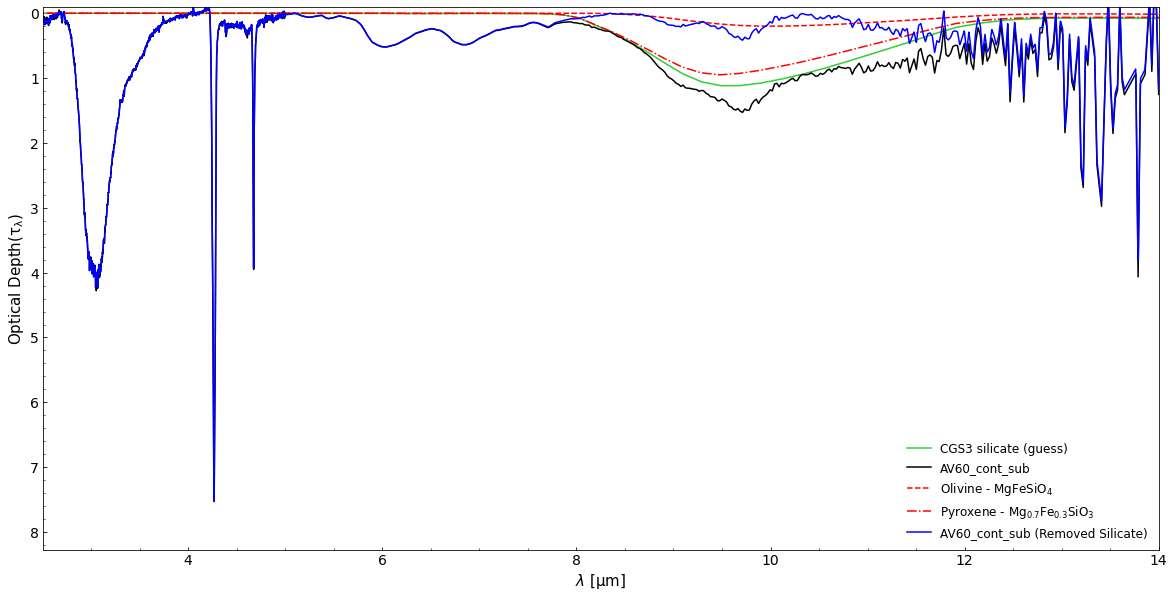

In [6]:
filename = 'AV60_cont_sub.od'
extract_silicate_M2(filename, 2.5, 28., 5000, ol_fac=0.20, pyr_fac=0.95)